<a href="https://colab.research.google.com/github/Medianto09/General-Text-Analysis/blob/main/General_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Sentiment Analysis

This exercise aims to create a sentimental analysis that can be used in a variety of text analyses to use variable data.

data used from carant-ai/indonesian_sentiment_datasets obtained from hugging faces with the amount of data of 1.030.393 rows but due to resources limitations then limited to 30,000 rows or 30% of the data

This Sentiment analysis model uses two models - Logistic Regression model - Naive Bayes's model Logisitic regression model looks better in this case

Deployment uses a Logistic Regression model with the extraction of the topic from positive, neutral and negative sentiment so that the user knows what the topic should be concerned about.

This exercise is limited to 30,000 rows and needs to be implemented with more data and using other models as well as need to be enhanced related to lematisation and stemming

# Library & Environment

In [85]:
!pip install wordcloud
!pip install joblib

In [86]:
!pip install datasets

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import numpy as np
import joblib
import seaborn as sns

import joblib

In [88]:
from datasets import load_dataset
from datasets import DatasetDict
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB





# Load & Understand Dataset

In [89]:
# Load the carant-ai/indonesian_sentiment_dataset dataset
dataset = load_dataset("carant-ai/indonesian_sentiment_dataset")
# Access the 'train' split of the dataset
train_dataset = dataset['train']
# Print the number of examples in the training dataset
print(f"Number of examples in training set: {len(train_dataset)}")
# Print the first example from the training set
print(train_dataset[0])


Number of examples in training set: 1030393
{'text': 'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !', 'label_text': 'positive', 'source': 'indonlp/indonlu/smsa', 'split': 'train'}


In [90]:
# Convert the train_dataset to a DatasetDict
train_dataset_dict = DatasetDict({"train": train_dataset})
# Convert the 'train' split to a Pandas DataFrame for display
df = pd.DataFrame(train_dataset_dict["train"])
# Display the DataFrame as a table
display(df)


,text,label_text,source,split
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,indonlp/indonlu/smsa,train
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,indonlp/indonlu/smsa,train
2,lokasi strategis di jalan sumatera bandung . t...,positive,indonlp/indonlu/smsa,train
3,betapa bahagia nya diri ini saat unboxing pake...,positive,indonlp/indonlu/smsa,train
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,indonlp/indonlu/smsa,train
...,...,...,...,...
1030388,"Pengiriman lebih cepat , packing rapih Dan ba...",positive,grikomsn/lazada-indonesian-reviews,train
1030389,I can't login to activated this netbook becaus...,negative,grikomsn/lazada-indonesian-reviews,train
1030390,"barang ok, pengiriman super lambat dn trpaksa ...",negative,grikomsn/lazada-indonesian-reviews,train
1030391,"mantapp,, terima kasih lazadaaa,, tv coocaa 40...",positive,grikomsn/lazada-indonesian-reviews,train


In [91]:
# Get descriptive statistics of the DataFrame
descriptive_stats = df.describe()
# Display the descriptive statistics
display(descriptive_stats)


,text,label_text,source,split
count,1030393,1030393,1030393,1030393
unique,1028149,3,12,7
top,0,positive,FDR Dataset,train
freq,418,640685,702632,876474


Index(['text', 'label_text', 'source', 'split'], dtype='object')


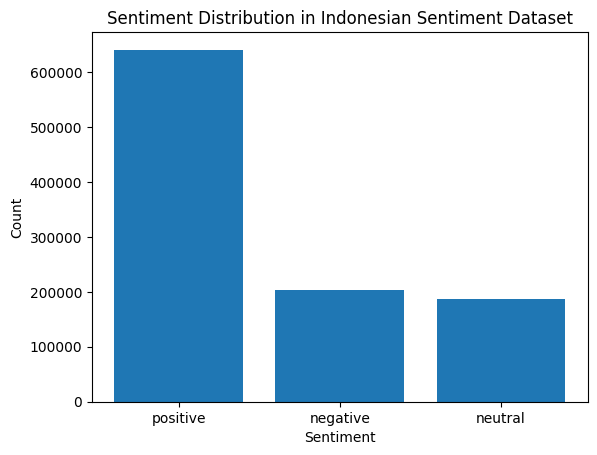

In [92]:
# Check the available columns in your DataFrame
print(df.columns)
# Assuming the sentiment column is named 'label', adjust accordingly
sentiment_column = df['label_text']
# Get the count of each sentiment value
sentiment_counts = sentiment_column.value_counts()
# Create a bar chart of the sentiment counts
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Indonesian Sentiment Dataset')
plt.show()




# EDA & Data Preprocessing

text          0
label_text    0
source        0
split         0
dtype: int64
2200
label_text
positive    640685
negative    203606
neutral     186102
Name: count, dtype: int64


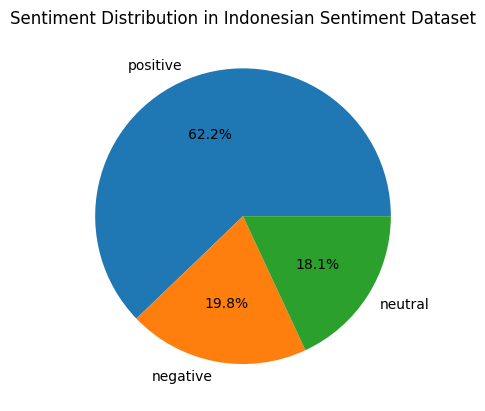

In [93]:

# Check for missing values
missing_values = df.isnull().sum()
# Print the number of missing values in each column
print(missing_values)
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
# Print the number of duplicate rows
print(duplicate_rows)
# Check the distribution of sentiment values
sentiment_counts = df['label_text'].value_counts()
# Print the sentiment counts
print(sentiment_counts)
# Create a pie chart of the sentiment distribution
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution in Indonesian Sentiment Dataset')
plt.show()


In [94]:


def preprocess_text(text):
  # Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Convert text to lowercase
  text = text.lower()
  # Remove extra whitespace
  text = ' '.join(text.split())
  return text

# Apply the preprocess_text function to the 'text' column
train_dataset_dict['train'] = train_dataset_dict['train'].map(lambda example: {'text': preprocess_text(example['text']), 'label_text': example['label_text']})

In [95]:
# Save the preprocessed dataset to a new file
train_dataset_dict.save_to_disk("preprocessed_train_dataset")


Saving the dataset (0/1 shards):   0%|          | 0/1030393 [00:00<?, ? examples/s]

In [96]:

# Load the preprocessed dataset from disk
preprocessed_dataset = DatasetDict.load_from_disk('preprocessed_train_dataset')
# Access the 'train' split of the preprocessed dataset
train_preprocessed = preprocessed_dataset['train']
# Convert the 'train' split to a Pandas DataFrame for display
df_preprocessed = pd.DataFrame(train_preprocessed)
# Display the DataFrame as a table
display(df_preprocessed)


,text,label_text,source,split
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,indonlp/indonlu/smsa,train
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,indonlp/indonlu/smsa,train
2,lokasi strategis di jalan sumatera bandung tem...,positive,indonlp/indonlu/smsa,train
3,betapa bahagia nya diri ini saat unboxing pake...,positive,indonlp/indonlu/smsa,train
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,indonlp/indonlu/smsa,train
...,...,...,...,...
1030388,pengiriman lebih cepat packing rapih dan baran...,positive,grikomsn/lazada-indonesian-reviews,train
1030389,i cant login to activated this netbook because...,negative,grikomsn/lazada-indonesian-reviews,train
1030390,barang ok pengiriman super lambat dn trpaksa j...,negative,grikomsn/lazada-indonesian-reviews,train
1030391,mantapp terima kasih lazadaaa tv coocaa 40 sud...,positive,grikomsn/lazada-indonesian-reviews,train


# Limit data for this simulation into 30.000

In [97]:
# Get the indices of all examples in the preprocessed_dataset
all_indices = list(range(len(preprocessed_dataset["train"])))

# Randomly select 10.000 indices for each sentiment label
positive_indices = random.sample([i for i, label in enumerate(preprocessed_dataset["train"]) if label["label_text"] == "positive"], 10000)
neutral_indices = random.sample([i for i, label in enumerate(preprocessed_dataset["train"]) if label["label_text"] == "neutral"], 10000)
negative_indices = random.sample([i for i, label in enumerate(preprocessed_dataset["train"]) if label["label_text"] == "negative"], 10000)

# Combine the indices for all sentiment labels
selected_indices = positive_indices + neutral_indices + negative_indices

# Select the examples at the selected indices
selected_examples = [preprocessed_dataset["train"][i] for i in selected_indices]

# Create a new DatasetDict with the selected examples
selected_dataset = DatasetDict({"train": selected_examples})

# Convert the 'train' split to a Pandas DataFrame for display
df_selected = pd.DataFrame(selected_dataset["train"])

# Display the DataFrame as a table
display(df_selected)

,text,label_text,source,split
0,dulu sempet punya sebelum sekarang langganan y...,positive,FDR Dataset,train
1,bagus skali,positive,alexmariosimanjuntak/dana-app-sentiment-review...,train
2,mudah di blend dan aku suka teksturnya yg thic...,positive,FDR Dataset,test
3,jadii ini ceritanya aku beli karna habis nonto...,positive,FDR Dataset,train
4,barang nya pagus n jahitan rapi,positive,grikomsn/lazada-indonesian-reviews,train
...,...,...,...,...
29995,awal2 pake ini ga kerasa apa2 tapi di atas 10 ...,negative,FDR Dataset,test
29996,barang sesuai pesanan tpi kantong terlalu pendek,negative,christofel04/review-lapak-sentiment,train
29997,sudah di test tapi ada yg cepat ngedrop ya,negative,christofel04/review-lapak-sentiment,train
29998,sangatt membantau,negative,itanium/livin-by-mandiri-app-reviews,train


In [98]:
# Convert the selected_dataset to a Pandas DataFrame
df_random_selected = pd.DataFrame(selected_dataset["train"])
# Save the DataFrame to a CSV file
df_random_selected.to_csv("selected_indonesian_sentiment_data.csv", index=False)

In [99]:
df_random_selected.head()


,text,label_text,source,split
0,dulu sempet punya sebelum sekarang langganan y...,positive,FDR Dataset,train
1,bagus skali,positive,alexmariosimanjuntak/dana-app-sentiment-review...,train
2,mudah di blend dan aku suka teksturnya yg thic...,positive,FDR Dataset,test
3,jadii ini ceritanya aku beli karna habis nonto...,positive,FDR Dataset,train
4,barang nya pagus n jahitan rapi,positive,grikomsn/lazada-indonesian-reviews,train


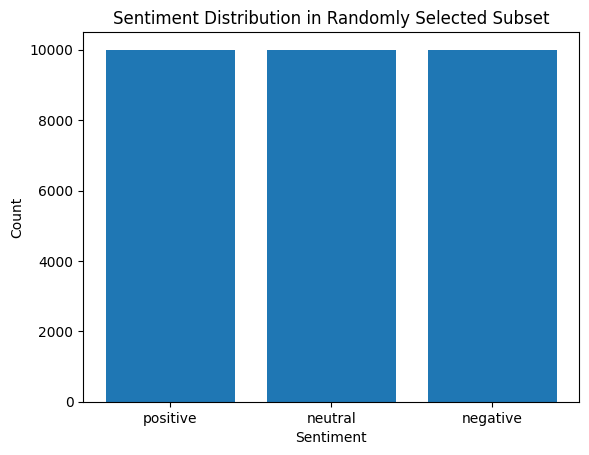

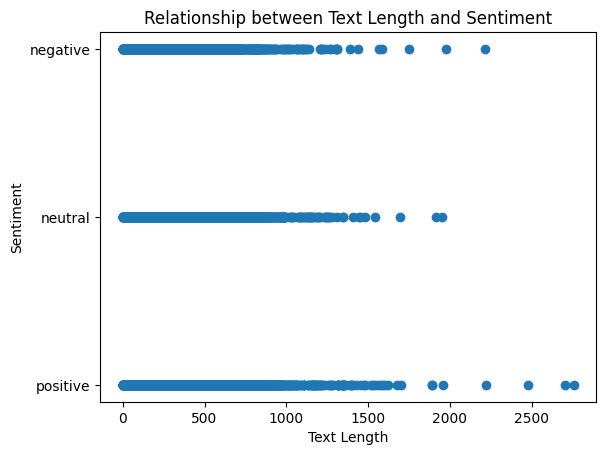

In [100]:

# Convert the selected_dataset to a Pandas DataFrame
df_random_selected = pd.DataFrame(selected_dataset["train"])

# Plot the distribution of sentiment values
plt.bar(df_random_selected['label_text'].value_counts().index, df_random_selected['label_text'].value_counts().values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Randomly Selected Subset')
plt.show()

# Plot the relationship between sentiment and text length
plt.scatter(df_random_selected['text'].str.len(), df_random_selected['label_text'])
plt.xlabel('Text Length')
plt.ylabel('Sentiment')
plt.title('Relationship between Text Length and Sentiment')
plt.show()


In [101]:


# Calculate the average length of text for each sentiment label:
average_lengths = {}
for sentiment in ['positive', 'neutral', 'negative']:
  sentiment_data = df[df['label_text'] == sentiment]
  average_length = sentiment_data['text'].str.len().mean()
  average_lengths[sentiment] = average_length

print(f"Average text length for positive sentiment: {average_lengths['positive']}")
print(f"Average text length for neutral sentiment: {average_lengths['neutral']}")
print(f"Average text length for negative sentiment: {average_lengths['negative']}")

# YExplore the use of punctuation by calculating the average number of punctuation marks per text:
average_punctuation = {}
for sentiment in ['positive', 'neutral', 'negative']:
  sentiment_data = df[df['label_text'] == sentiment]
  punctuation_count = sentiment_data['text'].str.count(r'[^\w\s]+').mean()
  average_punctuation[sentiment] = punctuation_count

print(f"Average punctuation for positive sentiment: {average_punctuation['positive']}")
print(f"Average punctuation for neutral sentiment: {average_punctuation['neutral']}")
print(f"Average punctuation for negative sentiment: {average_punctuation['negative']}")


Average text length for positive sentiment: 293.5310831375793
Average text length for neutral sentiment: 266.58053647999486
Average text length for negative sentiment: 193.3433297643488
Average punctuation for positive sentiment: 6.798045841560205
Average punctuation for neutral sentiment: 6.376551568494697
Average punctuation for negative sentiment: 4.352214571279824


# Data Spliting

In [102]:
# Split the data into train and test sets
train_data, test_data = train_test_split(df_random_selected, test_size=0.2, random_state=42)
# Split the train data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
# Print the number of examples in each set
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")
print(f"Number of test examples: {len(test_data)}")


Number of training examples: 19200
Number of validation examples: 4800
Number of test examples: 6000


In [103]:
# Load the selected_indonesian_sentiment_data.csv file into a Pandas DataFrame
df = pd.read_csv("selected_indonesian_sentiment_data.csv")
# Calculate the total word count for each text in the 'text' column
df['word_count'] = df['text'].str.split().str.len()
# Calculate the total word count for the entire dataset
total_word_count = df['word_count'].sum()
# Print the total word count
print(f"Total word count: {total_word_count}")


Total word count: 1199457.0


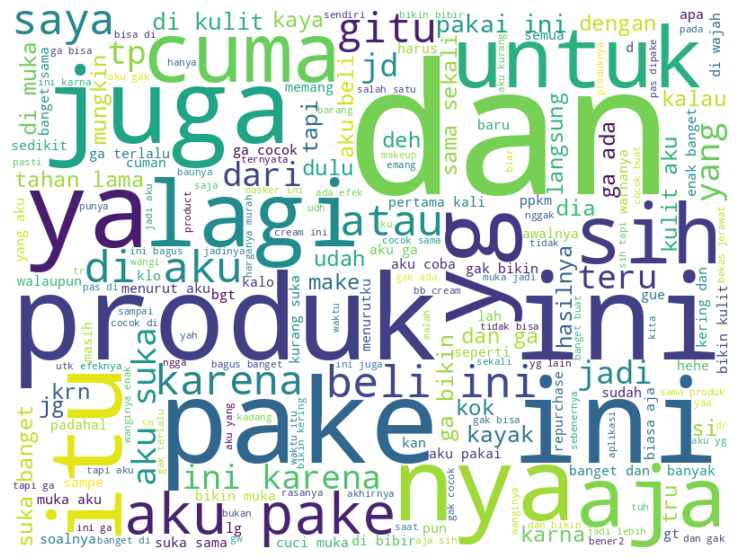

In [104]:
# Load the selected_indonesian_sentiment_data.csv file into a Pandas DataFrame
df = pd.read_csv("selected_indonesian_sentiment_data.csv")
# Convert all values in the 'text' column to strings
df['text'] = df['text'].astype(str) # Convert the column to string type to ensure all elements are strings
# Combine all the text into a single string
text = " ".join(df["text"].tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=600, background_color="white").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Vectorization

In [105]:
# Load the data
df = pd.read_csv("selected_indonesian_sentiment_data.csv")

# Handle missing values in the 'text' column
# Fill missing values with an empty string
df['text'] = df['text'].fillna('')

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'text' column
text_vectors = vectorizer.fit_transform(df['text'])

# Create a new DataFrame with the vectorized text and labels
vectorized_df = pd.DataFrame(text_vectors.toarray(), columns=vectorizer.get_feature_names_out())
vectorized_df['label_text'] = df['label_text']


Logistic Regression

# Logistic Regression Model

In [106]:

# Assuming 'label_text' is your target variable
X = vectorized_df.drop('label_text', axis=1)
y = vectorized_df['label_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.72      0.73      0.72      2002
     neutral       0.59      0.57      0.58      1996
    positive       0.71      0.73      0.72      2002

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000



In [107]:


# Save the vectorizer using joblib
filename_vec = 'vectorizer.pkl'
joblib.dump(vectorizer, filename_vec)
print(f"Vectorizer saved to {filename_vec}")


#Save the trained model using joblib
filename = 'trained_sentiment_modellogreg.pkl'
joblib.dump(model, filename)
print(f"Model saved to {filename}")


Vectorizer saved to vectorizer.pkl
Model saved to trained_sentiment_modellogreg.pkl


In [108]:
# Testing the model with new text
# Load the trained model
model = joblib.load('trained_sentiment_modellogreg.pkl')

# Load the vectorizer
vectorizer = joblib.load('vectorizer.pkl')

# Define a function to preprocess text
def preprocess_text(text):
  # Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Convert text to lowercase
  text = text.lower()
  # Remove extra whitespace
  text = ' '.join(text.split())
  return text

# Define a function to predict sentiment
def predict_sentiment(text):
  # Preprocess the text
  text = preprocess_text(text)
  # Vectorize the text
  text_vector = vectorizer.transform([text])
  # Predict the sentiment
  sentiment = model.predict(text_vector)[0]
  return sentiment

# Get new text from the user
new_text = input("Enter new text: ")

# Predict the sentiment of the new text
sentiment = predict_sentiment(new_text)

# Print the predicted sentiment
print(f"Predicted sentiment: {sentiment}")


Enter new text: kantor ini tidak nyaman untuk kerja
Predicted sentiment: negative


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Naive Bayes Model

Naive Bayes

In [109]:

# Load the vectorizer
vectorizer = joblib.load('vectorizer.pkl')

# Load the training data
df = pd.read_csv("selected_indonesian_sentiment_data.csv")

# Handle missing values in the 'text' column
# Fill missing values with an empty string
df['text'] = df['text'].fillna('')

# Initialize the Naive Bayes model
model = MultinomialNB()

# Fit the model
X = vectorizer.fit_transform(df['text'])
y = df['label_text']
model.fit(X, y)

# Save the model
filename = 'trained_sentiment_modelnb.pkl'
joblib.dump(model, filename)
print(f"Model saved to {filename}")


Model saved to trained_sentiment_modelnb.pkl


In [110]:
# Evaluate the model

# Load the saved model
model = joblib.load('trained_sentiment_modelnb.pkl')

# Load the vectorizer
vectorizer = joblib.load('vectorizer.pkl')

# Load the test data
test_df = pd.read_csv("selected_indonesian_sentiment_data.csv")

# Preprocess the test data
test_text = test_df['text'].fillna('').apply(preprocess_text)

# Vectorize the test data
X_test = vectorizer.transform(test_text)

# Predict the sentiment
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(test_df['label_text'], y_pred))


              precision    recall  f1-score   support

    negative       0.83      0.62      0.71     10000
     neutral       0.72      0.63      0.67     10000
    positive       0.67      0.92      0.78     10000

    accuracy                           0.73     30000
   macro avg       0.74      0.72      0.72     30000
weighted avg       0.74      0.72      0.72     30000



In [111]:
# simulate the model in new text

def predict_sentiment_nb(text):
  # Load the vectorizer
  vectorizer = joblib.load('vectorizer.pkl')

  # Load the trained model
  model = joblib.load('trained_sentiment_modelnb.pkl')

  # Preprocess the text
  text = preprocess_text(text)

  # Vectorize the text
  text_vector = vectorizer.transform([text])

  # Predict the sentiment
  sentiment = model.predict(text_vector)[0]

  # Print the predicted sentiment
  print(f"Predicted sentiment: {sentiment}")

# Get new text from the user
new_text = input("Enter new text: ")

# Predict the sentiment of the new text
predict_sentiment_nb(new_text)


Enter new text: kantor ini tidak enak untuk kerja
Predicted sentiment: negative


# Comparing Logistic Regression & Naive Bayes Model

In [112]:

# Load the Logistic Regression model
model_logreg = joblib.load('trained_sentiment_modellogreg.pkl')

# Load the Naive Bayes model
model_nb = joblib.load('trained_sentiment_modelnb.pkl')

# Load the vectorizer
vectorizer = joblib.load('vectorizer.pkl')

# Load the test data
test_df = pd.read_csv("selected_indonesian_sentiment_data.csv")

# Preprocess the test data
test_text = test_df['text'].fillna('').apply(preprocess_text)

# Vectorize the test data
X_test = vectorizer.transform(test_text)

# Predict the sentiment for both models
y_pred_logreg = model_logreg.predict(X_test)
y_pred_nb = model_nb.predict(X_test)

# Print the classification reports
print("Logistic Regression Model:")
print(classification_report(test_df['label_text'], y_pred_logreg))
print("Naive Bayes Model:")
print(classification_report(test_df['label_text'], y_pred_nb))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic Regression Model:
              precision    recall  f1-score   support

    negative       0.82      0.80      0.81     10000
     neutral       0.73      0.72      0.73     10000
    positive       0.80      0.83      0.81     10000

    accuracy                           0.78     30000
   macro avg       0.78      0.78      0.78     30000
weighted avg       0.78      0.78      0.78     30000

Naive Bayes Model:
              precision    recall  f1-score   support

    negative       0.83      0.62      0.71     10000
     neutral       0.72      0.63      0.67     10000
    positive       0.67      0.92      0.78     10000

    accuracy                           0.73     30000
   macro avg       0.74      0.72      0.72     30000
weighted avg       0.74      0.72      0.72     30000



# Deployment model

In [113]:
#  save new_text in user input column, sentiment in predicted_sentiment and date

def predict_sentiment_and_save(text):
  # Preprocess the text
  text = preprocess_text(text)
  # Vectorize the text
  text_vector = vectorizer.transform([text])
  # Predict the sentiment
  sentiment = model.predict(text_vector)[0]

  # Get the current date
  current_date = datetime.datetime.now().strftime("%Y-%m-%d")

  # Save the text, prediction, and date to a file
  with open("new_sentiment_predictions.csv", "a") as f:
    f.write(f"{text},{sentiment},{current_date}\n")

  return sentiment

# Load the trained model
model = joblib.load('trained_sentiment_modellogreg.pkl')

# Load the vectorizer
vectorizer = joblib.load('vectorizer.pkl')

while True:
  # Get new text from the user
  new_text = input("Enter new text (or 'quit' to exit): ")

  # Check if the user wants to quit
  if new_text == 'quit':
    break

  # Predict the sentiment of the new text
  sentiment = predict_sentiment_and_save(new_text)

  # Print the predicted sentiment
  print(f"Predicted sentiment: {sentiment}")

  # Save the new_text, predicted_sentiment, and date to a new DataFrame
  new_df = pd.DataFrame({'user_input': [new_text], 'predicted_sentiment': [sentiment], 'date': [current_date]})

  # Load the existing DataFrame from the CSV file
  existing_df = pd.read_csv("new_sentiment_predictions.csv")

  # Append the new data to the existing DataFrame
  combined_df = pd.concat([existing_df, new_df], ignore_index=True)

  # Save the combined DataFrame to the CSV file
  combined_df.to_csv("new_sentiment_predictions.csv", index=False)



Enter new text (or 'quit' to exit): kantor ini tidak nyaman untuk kerja


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Predicted sentiment: negative
Enter new text (or 'quit' to exit): atasannya menyebalkan


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Predicted sentiment: negative
Enter new text (or 'quit' to exit): perusahaan ini untungnya besar


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Predicted sentiment: negative
Enter new text (or 'quit' to exit): kantor ini untungnya besar


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Predicted sentiment: negative
Enter new text (or 'quit' to exit): quit


In [114]:
# display sentiment_predictions.csv

!cat new_sentiment_predictions.csv


makananya enak tempatnya juga enak,positive,2024-07-06,user_input,predicted_sentiment,date
makanan enak lho pelayanannya kurang,negative,2024-07-06,,,
pelayanaannya parah,negative,2024-07-06,,,
makanan lumayan,positive,2024-07-06,,,
tempatnya jauh banget dan macet,negative,2024-07-06,,,
jarak tempuh jauh dan macet,negative,2024-07-06,,,
tempatnya bagus,positive,2024-07-06,,,
makanannya lumayan enak,neutral,2024-07-06,,,
,,,makanannya lumayan enak,neutral,2024-07-06
tempatnya jauh banget,positive,2024-07-06,,,
,,,tempatnya jauh banget,positive,2024-07-06
tempatnya tidak nyaman,negative,2024-07-06,,,
,,,tempatnya tidak nyaman,negative,2024-07-06
tempatnya jauh dan macet,negative,2024-07-06,,,
,,,tempatnya jauh dan macet,negative,2024-07-06
manan enak,positive,2024-07-06,,,
,,,manan enak,positive,2024-07-06
kantor ini tidak nyaman untuk kerja,negative,2024-07-06,,,
,,,kantor ini tidak nyaman untuk kerja,negative,2024-07-06
atasannya menyebalkan,negative,2024-07-06,,,
,,,atasannya menyebal

In [115]:
# display last 10 entry
# Load the sentiment_predictions.csv file into a Pandas DataFrame
df = pd.read_csv("new_sentiment_predictions.csv")

# Display the last 10 entries
df.tail(10)


,makananya enak tempatnya juga enak,positive,2024-07-06,user_input,predicted_sentiment,date
14,manan enak,positive,2024-07-06,NaN,NaN,NaN
15,NaN,NaN,NaN,manan enak,positive,2024-07-06
16,kantor ini tidak nyaman untuk kerja,negative,2024-07-06,NaN,NaN,NaN
17,NaN,NaN,NaN,kantor ini tidak nyaman untuk kerja,negative,2024-07-06
18,atasannya menyebalkan,negative,2024-07-06,NaN,NaN,NaN
19,NaN,NaN,NaN,atasannya menyebalkan,negative,2024-07-06
20,perusahaan ini untungnya besar,negative,2024-07-06,NaN,NaN,NaN
21,NaN,NaN,NaN,perusahaan ini untungnya besar,negative,2024-07-06
22,kantor ini untungnya besar,negative,2024-07-06,NaN,NaN,NaN
23,NaN,NaN,NaN,kantor ini untungnya besar,negative,2024-07-06


<ipython-input-116-226ac994dc1b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['topic'] = positive_df['user_input'].str.split(' ').str[0]


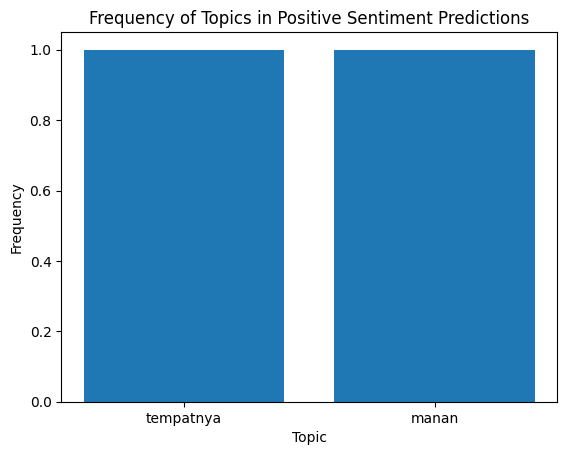

In [116]:
# display positive topic

# Load the sentiment_predictions.csv file into a Pandas DataFrame
df = pd.read_csv("new_sentiment_predictions.csv")

# Filter for positive predicted_sentiment
positive_df = df[df['predicted_sentiment'] == 'positive']

# Extract the user_input and topic
positive_df['topic'] = positive_df['user_input'].str.split(' ').str[0]

# Count the frequency of each topic
topic_counts_pos = positive_df['topic'].value_counts()

# Create a bar chart of the topic frequency
plt.bar(topic_counts_pos.index, topic_counts_pos.values)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Topics in Positive Sentiment Predictions')
plt.show()


<ipython-input-117-304fcd4576f5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df['topic'] = negative_df['user_input'].str.split(' ').str[0]


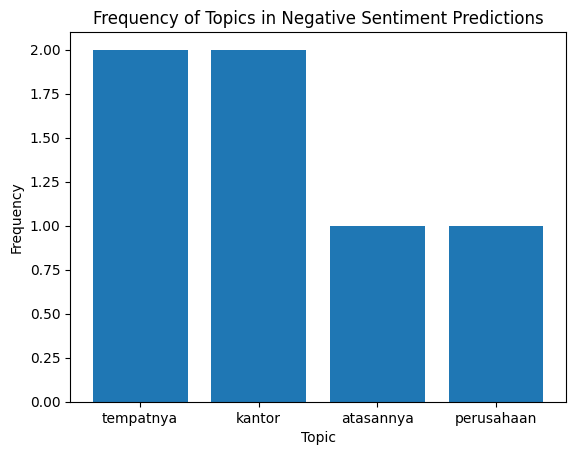

In [117]:
# display negative topic

# Load the sentiment_predictions.csv file into a Pandas DataFrame
df = pd.read_csv("new_sentiment_predictions.csv")

# Filter for negative predicted_sentiment
negative_df = df[df['predicted_sentiment'] == 'negative']

# Extract the user_input and topic
negative_df['topic'] = negative_df['user_input'].str.split(' ').str[0]

# Count the frequency of each topic
topic_counts_neg = negative_df['topic'].value_counts()

# Create a bar chart of the topic frequency
plt.bar(topic_counts_neg.index, topic_counts_neg.values)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Topics in Negative Sentiment Predictions')
plt.show()


<ipython-input-118-08e8110aa0f5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral_df['topic'] = neutral_df['user_input'].str.split(' ').str[0]


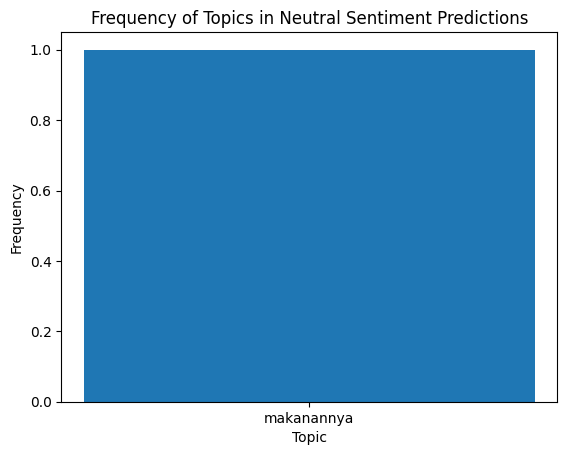

In [118]:
# display neutral topic

# Load the sentiment_predictions.csv file into a Pandas DataFrame
df = pd.read_csv("new_sentiment_predictions.csv")

# Filter for neutral predicted_sentiment
neutral_df = df[df['predicted_sentiment'] == 'neutral']

# Extract the user_input and topic
neutral_df['topic'] = neutral_df['user_input'].str.split(' ').str[0]

# Count the frequency of each topic
topic_counts_neu = neutral_df['topic'].value_counts()

# Create a bar chart of the topic frequency
plt.bar(topic_counts_neu.index, topic_counts_neu.values)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Topics in Neutral Sentiment Predictions')
plt.show()
